# GNOD 2

In [2]:
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
import requests

In [3]:
url = 'https://www.popvortex.com/music/charts/top-100-songs.php'

In [4]:
response = requests.get(url)
response.status_code 

200

getting the soup and prettifing that soup.

In [5]:
soup = BeautifulSoup(response.content, "html.parser")
# print(soup.prettify())

## Selector :

body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper

In [6]:
# soup.select('body > div.container > div:nth-child(4) > div.col-xs-12.col-md-8 > div.chart-wrapper')

In [7]:
# soup.select('div.chart-wrapper')

In [8]:
charts = soup.select('div.chart-wrapper p')
# charts

looking for artists and their songs

In [9]:
# soup.select("div.chart-wrapper p em")
# soup.select("div.chart-wrapper p cite")


creating lists

In [10]:
chart_position = []
song_title = []
artist = []


num_iter = len(soup.select('div.chart-wrapper p em'))
# num_iter = len(soup.select('p.title-artits'))

tClist = soup.select('div.chart-wrapper p cite')
tClist1 = soup.select('div.chart-wrapper p em')


for i in range(num_iter):
    song_title.append(tClist[i].get_text())
    artist.append(tClist1[i].get_text())
    
    chart_position.append(i+1)

# print(song_title)
# print(artist)
# print(chart_position)

dataframe of top 100 songs /w artists

In [11]:
top_100 = pd.DataFrame({'ranking':chart_position,
                    "title":song_title,
                       "artist":artist                    
                      })
# top_100.to_csv('top_100.csv', index = False)

# 1st prototype GNOD 2

inputs of songs title and artist name

In [12]:
user_song_title = input('Select a song:')
user_song_artist = input('Select an Artist:')

print(user_song_artist)
print('\n')
print(user_song_title)

flowers


checking for match in our Top 100 list 

In [14]:
user_selection = top_100[(top_100.title == user_song_title) & (top_100.artist == user_song_artist)].index
user_selection

Int64Index([], dtype='int64')

In [1]:
import random


If statement for a recommender

In [17]:
if user_selection.size == 0:
    print('Song not found, please try again for recommendations.') 
else:
    recommendation = random.randint(0, len(top_100))
while recommendation == user_selection:
    recommendation = random.randint(0, len(top_100))
display(top_100[top_100.index == recommendation])

Song not found, please try again for recommendations.


NameError: name 'recommendation' is not defined

Another method 

In [18]:
if top_100['title'].str.lower().str.contains(str(user_song_title).lower()).any() == True:
    print('We can recommend this song :', str(top_100['title'].sample(1)))
    # print('by :', str(top_100['artist'].lower()))
else:
    print('Song not found, please try again for recommendations.')


We can recommend this song : 5    Anti-Hero
Name: title, dtype: object


# getting the 10k playlist

In [5]:
from random import randint
from time import sleep
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [6]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]] = line.split(':')[1].strip()

Identify to spotify

In [7]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

getting the playlist of 10 K

In [8]:
playlist = sp.user_playlist_tracks("spotify", "6yPiKpy7evrwvZodByKvM9")
playlist["total"] 

10000

Function to extract all songs from a playlist

In [9]:
def get_playlist_tracks(playlist_id):
    playlist = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = playlist['items']
    while playlist['next']!=None:          # while there is still a next ply to go to
        playlist = sp.next(playlist)
        tracks = tracks + playlist['items']
        sleep(randint(1,2))
    return tracks

In [10]:
all_tracks = get_playlist_tracks("6yPiKpy7evrwvZodByKvM9")
len(all_tracks)

10000

function to get the dataframe with features

In [14]:
from pandas import json_normalize
import numpy as np
import pandas as pd 

In [24]:
def get_tracks(all_tracks):
    # track_list = []
    artists1 = []
    song_title1 = []
    song_uri1 = []
    my_features1 = []
    
    for i in range(len(all_tracks)):
        artists1.append(all_tracks[i]['track']['artists'][0]['name'])
        song_title1.append(all_tracks[i]['track']['name'])
        song_uri1.append(all_tracks[i]['track']['uri'])
                              
    my_data1 = pd.DataFrame({'artist': artists1, 'title': song_title1, 'uri': song_uri1})

    for i in range(len(all_tracks)):
        my_features1.append(my_data1['uri'][i].split(':')[-1])

    my_data_uri1 = pd.DataFrame({'artist': artists1, 'title': song_title1, 'features': my_features1})

    uris_feat_v3 = []
    stop_list = list(range(1,10000,100))

    for i in range(len(my_data_uri1['features'])):
        if i in stop_list:
            wait_time = random.randint(1,2)
            print('Napping for ',wait_time,'s')
            print(i)
            sleep(wait_time)      
        uris_feat_v3.append(sp.audio_features(my_data_uri1['features'][i]))
    
    my_data_clean1 = pd.DataFrame({'artists': artists1, 'titles': song_title1, 'audio_features': uris_feat_v3})
    flat_data = json_normalize(my_data_clean1['audio_features'])
    flat_data.columns = ['all_feats']
    flat_data_2 = json_normalize(flat_data['all_feats'])
    
    flat_data_clean1 = flat_data_2.drop(['mode', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'key'], axis = 1)

    my_data1 = (pd.concat([my_data_clean1, flat_data_clean1], axis = 1)).drop(['audio_features'], axis = 1)
    my_data1.to_csv('my_data.csv', index = False)
    
    return my_data1

In [25]:
get_tracks(all_tracks)

Napping for  1 s
1
Napping for  2 s
101
Napping for  1 s
201
Napping for  1 s
301
Napping for  1 s
401
Napping for  2 s
501
Napping for  1 s
601
Napping for  2 s
701
Napping for  2 s
801
Napping for  1 s
901
Napping for  2 s
1001
Napping for  2 s
1101
Napping for  2 s
1201
Napping for  1 s
1301
Napping for  1 s
1401
Napping for  1 s
1501
Napping for  2 s
1601
Napping for  2 s
1701
Napping for  1 s
1801
Napping for  1 s
1901
Napping for  1 s
2001
Napping for  1 s
2101
Napping for  1 s
2201
Napping for  2 s
2301
Napping for  2 s
2401
Napping for  1 s
2501
Napping for  1 s
2601
Napping for  1 s
2701
Napping for  1 s
2801
Napping for  1 s
2901
Napping for  2 s
3001
Napping for  2 s
3101
Napping for  1 s
3201
Napping for  2 s
3301
Napping for  1 s
3401
Napping for  1 s
3501
Napping for  1 s
3601
Napping for  1 s
3701
Napping for  1 s
3801
Napping for  2 s
3901
Napping for  2 s
4001
Napping for  2 s
4101
Napping for  1 s
4201
Napping for  1 s
4301
Napping for  1 s
4401
Napping for  2 s
4501


,artists,titles,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Nosaj Thing,2K,0.310,0.445,-13.355,0.0863,0.09400,0.067800,0.1130,0.122,95.360,152560.0
1,The Doors,4 Billion Souls,0.419,0.565,-11.565,0.0347,0.13700,0.337000,0.1280,0.648,151.277,197707.0
2,Radiohead,4 Minute Warning,0.354,0.302,-13.078,0.0326,0.59000,0.070900,0.1110,0.223,123.753,244285.0
3,Vitas,7 Element,0.727,0.785,-6.707,0.0603,0.32500,0.126000,0.3100,0.960,129.649,249940.0
4,R.E.M.,#9 Dream,0.571,0.724,-5.967,0.0260,0.02310,0.003110,0.0919,0.385,116.755,278320.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,The Clash,London Calling - Remastered,0.651,0.801,-7.340,0.0514,0.12300,0.000000,0.0825,0.776,133.769,200480.0
9996,War,Low Rider,0.811,0.647,-10.989,0.0498,0.08230,0.681000,0.0572,0.990,139.787,191560.0
9997,Moby,Flower,0.686,0.610,-5.902,0.0262,0.19000,0.000931,0.0710,0.766,80.567,206293.0
9998,The Cat Empire,Brighter Than Gold,0.711,0.718,-5.739,0.0380,0.00824,0.002080,0.0732,0.688,117.071,200293.0


In [26]:
import time

# CLustering using K-means 

import the csv file 

In [27]:
data = pd.read_csv('my_data.csv')
# data

defining our set 

In [28]:
raw_X = data.drop(['artists', 'titles'], axis =1)
# raw_X

checking for missing values

In [29]:
raw_X.isna().sum()

danceability        82
energy              82
loudness            82
speechiness         82
acousticness        82
instrumentalness    82
liveness            82
valence             82
tempo               82
duration_ms         82
dtype: int64

dropping missing values for our train set (82 out of 10K is negligeable)

In [31]:
X = raw_X.dropna()
X.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,9918.0,0.567745,0.158788,0.0,0.4620,0.575000,0.680000,0.980
energy,9918.0,0.618056,0.234337,0.0,0.4590,0.654000,0.811000,0.998
loudness,9918.0,-8.169800,4.299080,-60.0,-9.9270,-7.258500,-5.309000,-0.475
speechiness,9918.0,0.072924,0.082400,0.0,0.0335,0.043450,0.070700,0.963
acousticness,9918.0,0.291582,0.316008,0.0,0.0233,0.148000,0.525000,0.996
instrumentalness,9918.0,0.118390,0.261564,0.0,0.0000,0.000116,0.030075,0.996
liveness,9918.0,0.191876,0.163641,0.0,0.0966,0.124000,0.237000,0.997
valence,9918.0,0.485370,0.247855,0.0,0.2870,0.477000,0.682000,0.991
tempo,9918.0,120.397229,28.706183,0.0,99.0895,119.977000,137.979750,239.964
duration_ms,9918.0,232197.727667,86185.027422,7240.0,189909.7500,221894.000000,258696.000000,1967427.000


cheching for type before processing

In [32]:
X.dtypes

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
dtype: object

## Preprocessing

In [34]:
from sklearn.preprocessing import StandardScaler

## K-means

In [35]:
X_prep = StandardScaler().fit_transform(X)

# dataframe
pd.DataFrame(X_prep, columns = X.columns).head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-1.623287,-0.738529,-1.206179,0.162338,-0.625276,-0.193424,-0.482032,-1.466130,-0.872233,-0.924079
1,-0.936802,-0.226420,-0.789790,-0.463909,-0.489196,0.835823,-0.390363,0.656181,1.075773,-0.400214
2,-1.346174,-1.348792,-1.141744,-0.489396,0.944383,-0.181572,-0.494254,-1.058614,0.116907,0.140255
3,1.002990,0.712446,0.340276,-0.153213,0.105755,0.029095,0.721886,1.915043,0.322308,0.205873
4,0.020498,0.452124,0.512414,-0.569497,-0.849648,-0.440757,-0.610979,-0.404975,-0.126886,0.535181


### choosing a k

Elbow method

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

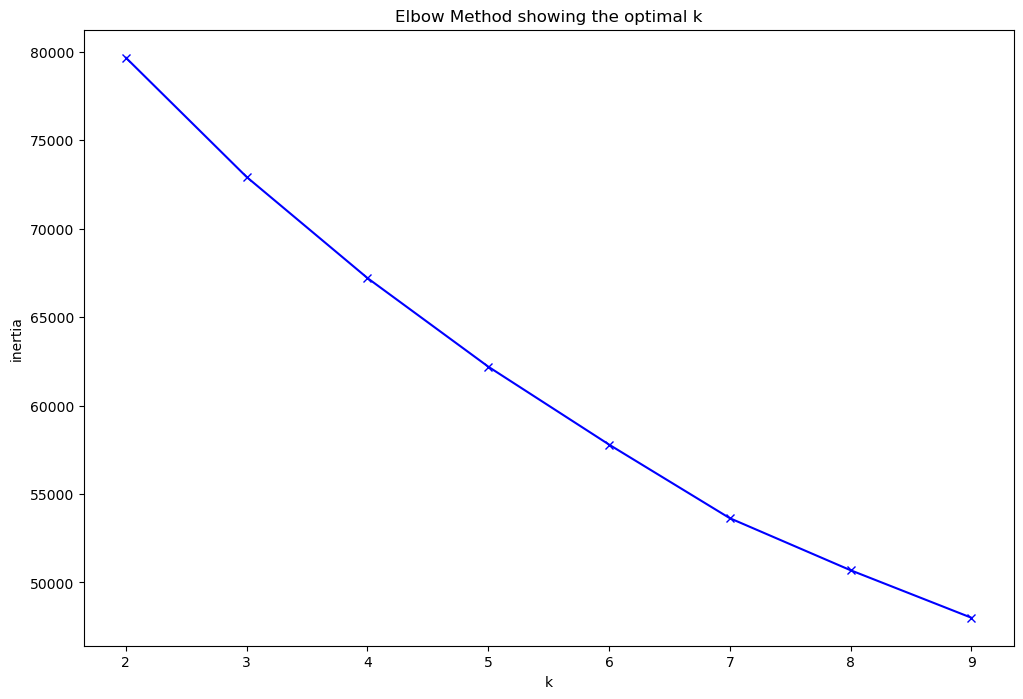

In [36]:
from sklearn.cluster import KMeans
K = range(2, 10)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters = k,
                    random_state = 88)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Silhouette method

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

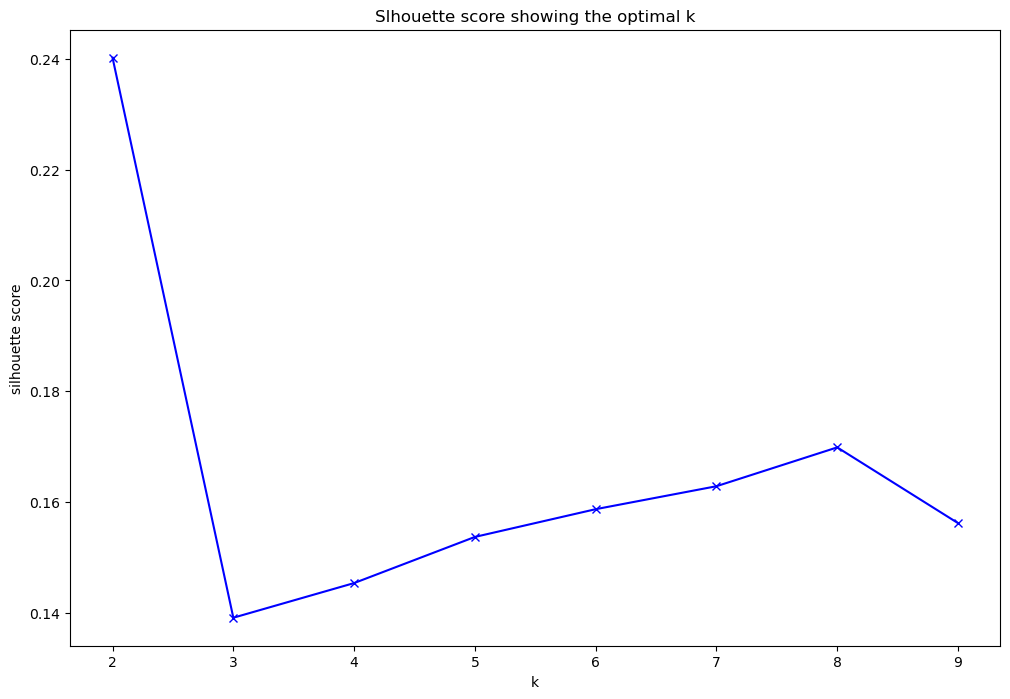

In [37]:
from sklearn.metrics import silhouette_score
K = range(2, 10)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters = k,
                    random_state = 88)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(12,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

According to the 2 methods i decided to select k = 8 as a number of cluster for my database

we can see in the silhouette method that the highest number of k is 2, but having only 2 clusters for ourr database is not pertinent. therefore we are going to select the second highest value for k witch is k = 8.

## Agglomerative clustering

In [38]:
from sklearn import cluster

In [39]:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    2084
1    2328
2     551
3     414
4    1412
5    1703
6     555
7     108
8     763
dtype: int64

Plotting the clusters (but really not helpfull, the visualisation is very poor here)

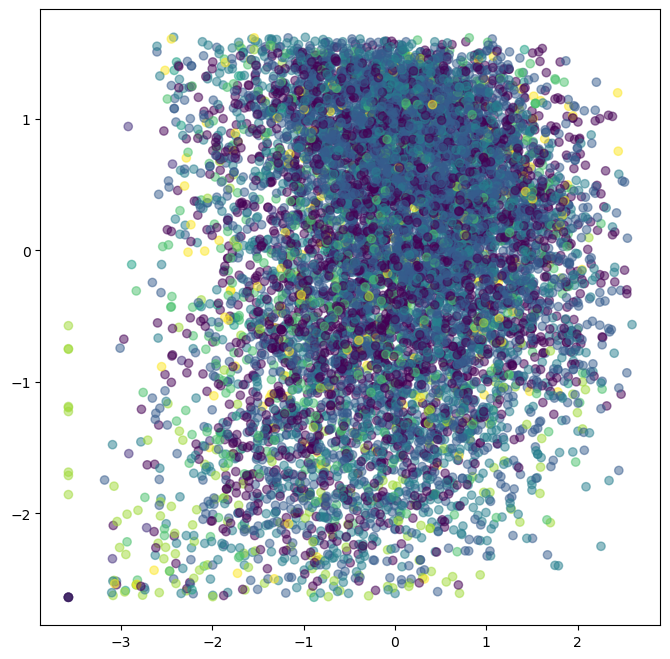

In [41]:
agglomerative = cluster.AgglomerativeClustering(n_clusters = 8,linkage='ward')
pred = agglomerative.fit_predict(X)

plt.figure(figsize = (8, 8))
plt.scatter(X_prep[:, 0], X_prep[:, 1], c = pred, alpha=0.5)
plt.show()

assign clusters to the dataframe

In [167]:
data_X_clusters = X.assign(clusters = clusters)
# data_X_clusters


Adding the cluster to the original dataframe

In [173]:
data_clusters = pd.concat([data, data_X_clusters], axis = 1)
# data_clusters
data_id = flattened_data.id
# data_id

In [174]:
final_data = pd.concat([data_clusters, data_id],axis =1)
# final_data

Testing clusters

# Recommender

We are going to build a function based on the cluster we assigned and the inputs of the user

In [ ]:
data_clusters[data_clusters['clusters'] == 6]
# data_clusters[data_clusters['artists'] == 'The Beatles']

# Recommender v2

Adapting the scalers for the recommender

In [142]:
scaler = StandardScaler()
scaler_rec = StandardScaler().fit(X)

In [176]:
user_song_title = input('Select a song:').lower()
user_song_artist = input('Select an artist:').lower()
# user_selection = top_100[(top_100.title == user_song_title) & (top_100.artist == user_song_artist)].index

# # if the song is in the top 100 , recommendation for another top 100

if top_100['title'].str.lower().str.contains(str(user_song_title).lower()).any() == True:
    print('here what I found for you! ')
    print(top_100['title'].sample().to_string())
    
    
# if the song is not in the top 100 recommendation for songs in the 10k playlist
else:

    # getting the song
    results = sp.search(q = user_song_title + user_song_artist, type = 'track', limit= 20)
    # getting the uri
    song_uri_v = results['tracks']['items'][0]['uri']
    #getting the features
    song_features = sp.audio_features(song_uri_v)
    #get the dataframe for the features
    df = pd.DataFrame.from_dict(song_features)
    rec_pred = df.drop(columns=['type', 'id' , 'key', 'uri', 'mode', 'track_href','time_signature', 'analysis_url'], axis =1)
    rec_pred_scaled = scaler_rec.transform(rec_pred)
    rec_pred_scaled_df = pd.DataFrame(rec_pred_scaled, columns = rec_pred.columns)

    
    # use the Kmeans created before to predict the cluster for the song
    look_for = kmeans.predict(rec_pred_scaled_df)
    print('Looking for more options, ...')
    print('\n')
    
    # choosing 2 random row from the playlist with same cluster as the input song
    a = (final_data.loc[final_data.clusters == look_for[0],['titles','artists','id']].sample(2))
    
    print('You may want to try this song:', ('' + a.iloc[0,0] + ''))  
    print('Perform by :', ('' + a.iloc[0,1] + ''))
    print('URL:',"https://open.spotify.com/track/" + a.iloc[0,2] + "?si=b7b938ef36254e36&nd=1")
    print('\n')
    print('Or try this song instead :', a.iloc[1,0])  
    print('Perform by :', a.iloc[1,1])
    print('URL:',"https://open.spotify.com/track/" + a.iloc[1,2] + "?si=b7b938ef36254e36&nd=1")



Looking for more options, ...


You may want to try this song: Bros
Perform by : Wolf Alice
URL: https://open.spotify.com/track/6NunWZuZ6g9KipJ9Q5Vck7?si=b7b938ef36254e36&nd=1


Or try this song instead : The Hum
Perform by : Alex Calder
URL: https://open.spotify.com/track/1lC1hUA7qM7yikVBDBfku0?si=b7b938ef36254e36&nd=1


c:\Users\Emmanuel\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [166]:
# user_artist = input('Enter an artist you want to listen to : ', ).lower()
# user_song = input('Enter the song you would like to listen to :', ).lower()

# music = [user_artist, user_song]

# if user_song in top_100.values:
#     print('We can suggest this song after.')
#     print("\n")
#     print(str(top_100.sample(n = 1)).title())

# elif music[0] in top_100.values:
#     print('Try this another one.')
#     print("\n")
#     print(str(top_100.sample(n = 1)).title())

# elif user_song not in top_100.values:
#     # try:
#         # results = sp.search(q = 'track:' + ('' + user_song + '') + 'artist:' + ('' + user_artist + ''), type = 'track', limit = 1)
#         results = sp.search(q = "track:" + user_song + 'artist' + user_artist, type = "track", limit = 10)
#         song_uri_v = results['tracks']['items'][0]['uri']
#         audio_features_recom = sp.audio_features(song_uri_v)

#         audio_features_recom = json_normalize(audio_features_recom)
#         audio_features_recom = audio_features_recom.drop(['key', 'mode', 'id', 'type', 'track_nerf', 'uri', 'analysis_uri'], axis =1)

#         audio_features_recom_scaled = scaler.fit_transform(audio_features_recom)

#         cluster_recom = kmeans.predict(audio_features_recom_scaled)
#         cluster_recom = pd.DataFrame(cluster_recom)
#         cluster_recom.columns = ['pred']

#         # choosing for a cluster in a dataframe
#         pd.options.display.max_colwidth = 300
#         songs_recom = pd.merge(left = cluster_recom,
#                                right = data_clusters,
#                                 how = 'inner',
#                                 left_on= 'cluster_recom',
#                                 right_on= 'clusters')


#         rec_song = songs_recom[['artists', 'title']].sample(n =1)
#         rec_artist = songs_recom['artists'].to_string(index = False)
#         rec_title = songs_recom['title'].to_string(index = False)

#         print('We recommende this song:'+ rec_title + 'by' + rec_artist)

#     # except:
#     #     print('\n Please enter another song and artist')
# else:
#     print('We cannot recommend anything at the moment')





